## *Facial Markers of IEMOCAP database* ##

# Loading datasets

In [1]:
# to be completed
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [2]:
%cd /content/drive/'My Drive'/'IEMOCAP_full_release_withoutVideos_sentenceOnly'/'IEMOCAP_full_release'

/content/drive/.shortcut-targets-by-id/1H_wIpsIF42ILnS8ZNz7BovI5ga272ikl/IEMOCAP_full_release_withoutVideos_sentenceOnly/IEMOCAP_full_release


In [3]:
!pwd

/content/drive/.shortcut-targets-by-id/1H_wIpsIF42ILnS8ZNz7BovI5ga272ikl/IEMOCAP_full_release_withoutVideos_sentenceOnly/IEMOCAP_full_release


# Importing necessary packages

In [4]:
!pip install tensorboardX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 4.0 MB/s eta 0:00:00


In [5]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.backend_bases import RendererBase
from scipy import signal
from scipy.io import wavfile
import os
from PIL import Image
from scipy.fftpack import fft
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tensorboardX import SummaryWriter

# Preprocessing the data

From the provided functions to pre-proccess the database in the drive given by our supervisors

In [6]:
def get_labels(annot_file, file_name):

    f = open(annot_file, 'r').read()
    f = f.split('\n')
    f = f[2:]

    for data in f:

        if len(data) > 0:
            if data[0] == '[':
                data2 = data.split('\t')

                if data2[1] == file_name:
                    emo = data2[2]
                    vad = data2[3][1:-1].split(', ')
                    return emo, [float(x) for x in vad]

    raise ValueError('Label not found')

def get_mocap_rot(path):

    f = open(path, 'r').read()
    f = np.array(f.split('\n'))
    header = f[0].split(' ')
    xyz = f[1].split(' ')
    f = f[2:]
    data_list = []

    for data in f:
        data2 = data.split(' ')
        if(len(data2)<2):
            continue
        dic = {'frame': data2[0], 'time': data2[1],
               'markers': np.array(data2[2:]).astype(float)}
        data_list.append(dic)

    return header, xyz, data_list

def get_wav(path):
    x, sr = librosa.load(path, sr=16000)
    return x, sr

def get_ph_fa(path):
    f = open(path, 'r').read()
    f = np.array(f.split('\n'))
    header = f[0].split()
    f = f[1:-2]
    data_list = []

    for data in f:
        data2 = data.split()
        dic = {'SFrm':np.array(data2[0]).astype(int),
               'EFrm':np.array(data2[1]).astype(int),
               'SegAScr':np.array(data2[2]).astype(int),
               'Phone':data2[3]}
        data_list.append(dic)

    return header, data_list

def frame_to_s(fr):
    return (fr+2)*10/1000

Balancing and cleaning the data

In [7]:
import pandas
root_path = '/content/drive/.shortcut-targets-by-id/1H_wIpsIF42ILnS8ZNz7BovI5ga272ikl/IEMOCAP_full_release_withoutVideos_sentenceOnly'

df = pandas.read_csv(os.path.join(root_path, 'iemocap.csv'))
sessions = [1, 2, 3, 4, 5]
df = df[df['session'].isin(sessions)]

# Remove unwanted emotions and empty values
unwanted_emotions = ['xxx', '', 'oth', 'dis', 'sur', 'fea']
df = df[~df['emotion'].isin(unwanted_emotions)]

# Calculate annotator difference
df['annotator_difference'] = df['n_annotators'] - df['agreement']

# Filter by annotator difference
df = df[df['annotator_difference'] <= 1]

# Replace 'exc' emotion with 'hap'
df.loc[df['emotion'] == 'exc', 'emotion'] = 'hap'


emotions_count_before = df['emotion'].value_counts()
print("Emotions count before filtering:")
print(emotions_count_before)

# Group by emotion and select first 900 rows of each group
df = df.groupby('emotion').head(900)

# Count the occurrences of each emotion after filtering
emotions_count_after = df['emotion'].value_counts()
print("\nEmotions count after filtering:")
print(emotions_count_after)

# Display the first 5 rows
display(df)
#Ntotal = 5531 utterances that are labeled with one of
#five categories: Happy, Angry, Neutral, Sad, Exited. This set is
#mapped down to four categories by merging Exited and Happy


Emotions count before filtering:
fru    1692
neu    1551
hap    1471
ang    1077
sad    1000
Name: emotion, dtype: int64

Emotions count after filtering:
neu    900
fru    900
ang    900
hap    900
sad    900
Name: emotion, dtype: int64


,Unnamed: 0,session,method,gender,n_annotators,agreement,emotion,valence,activation,dominance,wav_path,MOCAP_rotated_path,MOCAP_head_path,MOCAP_hand_path,FA_ph_path,FA_st_path,FA_sy_path,FA_wd_path,annotator_difference
0,0,1,script,F,3,3,neu,2.5,2.0,2.0,IEMOCAP_full_release/Session1/sentences/wav/Se...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,0
1,1,1,script,F,3,2,fru,2.5,2.0,2.5,IEMOCAP_full_release/Session1/sentences/wav/Se...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,1
4,4,1,script,F,3,2,neu,2.0,3.0,3.0,IEMOCAP_full_release/Session1/sentences/wav/Se...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,1
6,6,1,script,F,3,2,ang,2.0,3.5,3.0,IEMOCAP_full_release/Session1/sentences/wav/Se...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,1
7,7,1,script,F,3,2,ang,2.0,3.5,2.5,IEMOCAP_full_release/Session1/sentences/wav/Se...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9643,9643,5,impro,F,3,2,sad,2.0,2.5,1.5,IEMOCAP_full_release/Session5/sentences/wav/Se...,IEMOCAP_full_release/Session5/sentences/MOCAP_...,IEMOCAP_full_release/Session5/sentences/MOCAP_...,IEMOCAP_full_release/Session5/sentences/MOCAP_...,IEMOCAP_full_release/Session5/sentences/Forced...,IEMOCAP_full_release/Session5/sentences/Forced...,IEMOCAP_full_release/Session5/sentences/Forced...,IEMOCAP_full_release/Session5/sentences/Forced...,1
9645,9645,5,impro,F,3,2,sad,1.5,2.0,1.5,IEMOCAP_full_release/Session5/sentences/wav/Se...,IEMOCAP_full_release/Session5/sentences/MOCAP_...,IEMOCAP_full_release/Session5/sentences/MOCAP_...,IEMOCAP_full_release/Session5/sentences/MOCAP_...,IEMOCAP_full_release/Session5/sentences/Forced...,IEMOCAP_full_release/Session5/sentences/Forced...,IEMOCAP_full_release/Session5/sentences/Forced...,IEMOCAP_full_release/Session5/sentences/Forced...,1
9646,9646,5,impro,F,3,2,sad,1.5,2.0,2.0,IEMOCAP_full_release/Session5/sentences/wav/Se...,IEMOCAP_full_release/Session5/sentences/MOCAP_...,IEMOCAP_full_release/Session5/sentences/MOCAP_...,IEMOCAP_full_release/Session5/sentences/MOCAP_...,IEMOCAP_full_release/Session5/sentences/Forced...,IEMOCAP_full_release/Session5/sentences/Forced...,IEMOCAP_full_release/Session5/sentences/Forced...,IEMOCAP_full_release/Session5/sentences/Forced...,1
9649,9649,5,impro,F,3,2,sad,1.5,3.5,1.5,IEMOCAP_full_release/Session5/sentences/wav/Se...,IEMOCAP_full_release/Session5/sentences/MOCAP_...,IEMOCAP_full_release/Session5/sentences/MOCAP_...,


# Preparing train / test datasets

We noticed that the tensor contains NaN values, and the input tensors vary in size depending on the duration of the recording. We favored the removal of tensors containing NaN values to avoid erroneous data. To address the issue of different sizes, initially, we attempted padding by adding zeros. However, the size of the tensors reached up to 515955. Therefore, we decided to average the tensor over the 165 facial landmarks to obtain a tensor of size 165 for each recording.

In [8]:
import torch

def mean_tensor(tensor):
    # Check that the size of the tensor is divisible by 165
    total_size = tensor.size(0)
    assert total_size % 165 == 0, "La taille du tenseur n'est pas divisible par 165"

    # Calculate the number of sub-tensors
    n = total_size // 165

    # Resize the tensor into a tensor of shape (number_of_sub-tensors, 165, ...)
    tensor = tensor.view(n, 165, -1)

    # Calculate the mean along dimension 0 (the sub-tensors)
    mean = torch.mean(tensor, dim=0)

    return mean


In [9]:

print(len(df))

num_samples = len(df)
train_end = int(num_samples * 0.7)
test_end = int(num_samples * 0.85)

train_data = df.iloc[:train_end]  # Selecting rows up to train_end

#display(train_data)
test_data = df.iloc[train_end:test_end]  # Selecting rows from train_end to test_end

#display(test_data)
eval_data = df.iloc[test_end:]  # Selecting rows from test_end onwards

train_features = []
train_labels = []
test_features = []
test_labels = []



for index , row in train_data.iterrows():
    session = row['session']
    method = row['method']
    gender = row['gender']
    emotion = row['emotion']
    n_annot = row['emotion']
    agreement = row['agreement']
    wav_path = row['wav_path']

    _, file_name = os.path.split(wav_path)

    annot_file = os.path.join(root_path, 'IEMOCAP_full_release',
                              'Session'+str(session),
                              'dialog', 'EmoEvaluation',
                              file_name[:-9] + '.txt')

    # get labels
    emo, vad = get_labels(annot_file, file_name[:-4])
    #print(vad)

    # get MOCAP data
    header_rot, xyz_rot, data_rot = get_mocap_rot(os.path.join(root_path, row['MOCAP_rotated_path']))


    tensor_all = torch.empty(0)
    for dic in data_rot:
      tensor = torch.tensor(dic['markers'])
      #tensor = F.normalize(tensor, p=2, dim=-1)
      if torch.isnan(tensor).any():
        # Move to the next tensor if the current tensor contains NaN values
        continue
      if emo == 'fru':   # to classify only the four emotions
        continue

      tensor_all = torch.cat((tensor_all, tensor), dim=0)


    #tensor_all = F.normalize(tensor_all, p=2, dim=-1)
    if tensor_all.numel() > 0:  # Check if tensor_all is not empty
        tensor_all = mean_tensor(tensor_all)
        tensor_all = tensor_all.squeeze()
        train_features.append(tensor_all)
        if emo == 'exc':   # merge happ  and exc to have a balanced train data
           emo = 'hap'
        train_labels.append(emo)



# the same process for test_dataset

for index, row in test_data.iterrows():

    session = row['session']
    method = row['method']
    gender = row['gender']
    emotion = row['emotion']
    n_annot = row['emotion']
    agreement = row['agreement']
    wav_path = row['wav_path']

    _, file_name = os.path.split(wav_path)

    annot_file = os.path.join(root_path, 'IEMOCAP_full_release',
                              'Session'+str(session),
                              'dialog', 'EmoEvaluation',
                              file_name[:-9] + '.txt')

    # get labels
    emo, vad = get_labels(annot_file, file_name[:-4])
    #print(vad)

    # get MOCAP data
    header_rot, xyz_rot, data_rot = get_mocap_rot(os.path.join(root_path, row['MOCAP_rotated_path']))
    tensor_all = torch.empty(0)
    for dic in data_rot:
      tensor = torch.tensor(dic['markers'])
      #tensor = F.normalize(tensor, p=2, dim=-1)
      if torch.isnan(tensor).any():
        # Passer au tensor suivant si le tensor contient des NaN
        continue
      if emo == 'fru':
        continue
      tensor_all = torch.cat((tensor_all, tensor), dim=0)



    if tensor_all.numel() > 0:  # Vérifie si tensor_all n'est pas vide
        tensor_all = mean_tensor(tensor_all)
        tensor_all = tensor_all.squeeze()
        test_features.append(tensor_all)
        if emo == 'exc':
           emo = 'hap'
        test_labels.append(emo)

#print(get_labels(annot_file, file_name[:-4]))
#print(vad)
#print(frame_to_s(data_ph[-1]['EFrm']))
#print(x.shape[0]/sr)
#print(data_rot[-1]['time'])
#print(len(data_rot))
#print(len(train_features))
#print(len(test_data))
#print(len(test_labels))
#print(len(train_labels))



4500


In [10]:
print(len(train_features))
print(len(test_features))
print(len(test_labels))
print(len(train_labels))
print(train_features[800])
print(len(train_features[1]))

max_lenght = max(len(train_features[i]) for i in range(len(train_features)))
min_lenght = min(len(train_features[i]) for i in range(len(train_features)))

a = train_features[0]
a = a.squeeze()
print(a)
print(a.size())



2412
438
438
2412
tensor([-3.1379e+01,  3.4376e+01, -5.3077e+01, -3.7570e+00,  2.2455e+01,
        -6.1640e+01,  2.3363e+01,  3.4031e+01, -5.6423e+01, -1.6255e+01,
         3.2458e+01,  9.6762e+01,  6.6634e-04,  2.8707e+01,  9.0328e+01,
         1.0815e+01,  3.2283e+01,  9.7150e+01,  4.3497e+01,  5.4266e+01,
        -4.7200e+01,  5.6441e+01,  6.3955e+01, -8.0882e+00,  5.0713e+01,
         5.4866e+01,  2.4193e+01,  4.0121e+01,  4.3330e+01, -9.8536e+00,
         4.8723e+01,  5.0349e+01,  6.8006e+00,  3.0066e+01,  4.0001e+01,
         7.3183e+00,  3.0558e+01,  4.4746e+01,  1.8677e+01,  1.3677e+01,
         3.2442e+01,  2.1448e+01, -4.9257e+01,  5.3386e+01, -4.2715e+01,
        -6.0761e+01,  6.1935e+01, -2.1791e+00, -5.6098e+01,  5.4965e+01,
         2.7970e+01, -4.6910e+01,  4.5259e+01, -2.3092e+00, -5.5021e+01,
         5.1264e+01,  1.1450e+01, -3.4150e+01,  4.0452e+01,  1.1006e+01,
        -3.5490e+01,  4.5356e+01,  2.2941e+01, -1.5241e+01,  3.3509e+01,
         2.3247e+01,  3.1964e+01,

In [11]:
X_train = np.array(train_features)
y_train = np.array(train_labels)
X_test = np.array(test_features)
y_test = np.array(test_labels)

import numpy as np


# Find the unique elements in y_train and their occurrences
unique_elements, counts = np.unique(y_train, return_counts=True)


print("Nombre d'éléments uniques dans y_train :", len(unique_elements))

for value, count in zip(unique_elements, counts):
    print(f"Valeur : {value}, Nombre d'occurrences : {count}")


Nombre d'éléments uniques dans y_train : 4
Valeur : ang, Nombre d'occurrences : 491
Valeur : hap, Nombre d'occurrences : 610
Valeur : neu, Nombre d'occurrences : 768
Valeur : sad, Nombre d'occurrences : 543


Balancing the data

In [13]:
import numpy as np

# Supposons que y_train est votre tableau numpy
# Assuming X_train, y_train, X_test, and y_test as NumPy arrays
X_train = np.array(train_features)
y_train = np.array(train_labels)
X_test = np.array(test_features)
y_test = np.array(test_labels)

# Finf unique element and their occurance in y_train
unique_elements, counts = np.unique(y_train, return_counts=True)

# adjust the occurances especially for hap and neu
hap_count = counts[np.where(unique_elements == 'hap')]
neu_count = counts[np.where(unique_elements == 'neu')]

print(hap_count)
print(neu_count)

hap_diff = 550 - hap_count
neu_diff = 550 - neu_count

# occurrences of 'hap' & 'neu'
hap_indices = np.where(y_train == 'hap')[0]
print(len(hap_indices))
neu_indices = np.where(y_train == 'neu')[0]

# Select a subset of indices to remove
hap_indices_to_remove = np.random.choice(hap_indices, size=100)
neu_indices_to_remove = np.random.choice(neu_indices, size=250)

# Concatenate the indices to remove
indices_to_remove = np.concatenate((hap_indices_to_remove, neu_indices_to_remove))

# Remove the corresponding elements in y_train and X_train
y_train = np.delete(y_train, indices_to_remove)
X_train = np.delete(X_train, indices_to_remove, axis=0)


unique_elements, counts = np.unique(y_train, return_counts=True)
print("Number of unique elements in y_train after adjustment :", len(unique_elements))


for value, count in zip(unique_elements, counts):
    print(f"Value : {value}, Nbre of occurrences : {count}")



[610]
[768]
610
Number of unique elements in y_train after adjustment : 4
Value : ang, Nbre of occurrences : 491
Value : hap, Nbre of occurrences : 524
Value : neu, Nbre of occurrences : 547
Value : sad, Nbre of occurrences : 543


In [14]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder

#add one dimension

X_train_tensor = torch.Tensor(np.array(X_train)).unsqueeze(1)
print(X_train_tensor)
X_test_tensor = torch.Tensor(np.array(X_test)).unsqueeze(1)


# Convert string labels to numerical labels using LabelEncoder
label_encoder = LabelEncoder()

# Convert labels to strings
y_train_str = y_train.astype(str)
y_test_str = y_test.astype(str)

y_train_encoded = label_encoder.fit_transform(y_train_str)
y_test_encoded = label_encoder.fit_transform(y_test_str)


y_train_tensor = torch.tensor(y_train_encoded).unsqueeze(1) # Convert to tensor and add a dimension
#print(y_train_tensor)
y_test_tensor = torch.tensor(y_test_encoded).unsqueeze(1)    # Convert to tensor and add a dimension


# Convert numerical labels to tensors
y_train_tensor = torch.tensor(y_train_encoded)
y_test_tensor = torch.tensor(y_test_encoded)


# Create one-hot encoded tensors
# Calculate the number of classes
num_classes = len(np.unique(y_train_encoded))

# Convert numerical labels to one-hot encoded tensors
y_train_onehot = torch.zeros(len(y_train_tensor), num_classes)
#print("Dimensions de y_train_onehot :", y_train_onehot.shape)
#print("Dimensions de y_train_tensor :", y_train_tensor.shape)

index_tensor = torch.arange(y_train_tensor.size(0)).unsqueeze(1)
y_train_onehot.scatter_(1, y_train_tensor.unsqueeze(1), 1)

y_test_onehot = torch.zeros(len(y_test_tensor), num_classes)
y_test_onehot.scatter_(1, y_test_tensor.unsqueeze(1), 1)


#Normalize
# Done already
X_train_normalized = X_train_tensor
X_test_normalized = X_test_tensor

# Create DataLoader for training and testing with normalized data
train_dataset = TensorDataset(X_train_normalized, y_train_onehot)
train_loader = DataLoader(train_dataset, batch_size = 14, shuffle=True)

test_dataset = TensorDataset(X_test_normalized, y_test_onehot)
test_loader = DataLoader(test_dataset, batch_size = 14, shuffle=False)





tensor([[[-29.2494,  35.4891, -54.8457,  ..., -45.2686,  56.2013, 130.7098]],

        [[-29.4026,  34.3585, -55.4751,  ..., -45.1050,  56.0296, 131.1647]],

        [[-29.0716,  35.0648, -55.8266,  ..., -45.1177,  55.8967, 131.1103]],

        ...,

        [[-23.9798,  37.1295, -56.9357,  ..., -45.2261,  44.9454, 121.1469]],

        [[-36.1333,  36.7956, -55.3132,  ..., -52.0207,  68.2824, 127.0464]],

        [[-34.8177,  34.6386, -57.5057,  ..., -51.3172,  65.3900, 128.2982]]])


In this section we will use the markers

Defining the three models used to train MocapHead/MocapFace/MocapHand  
Inspired from this paper : https://www.researchgate.net/publication/324558351_Multi-Modal_Emotion_recognition_on_IEMOCAP_Dataset_using_Deep_Learning


First Model for MocapHead / MocapHand

In [15]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=165, hidden_size=256, output_size=4):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        x = hn[-1, :, :]
        x = self.fc(x)
        x = self.relu(x)
        return x


Second Model for MocapHead/MocapHand

In [16]:
class DenseModel(nn.Module):
    def __init__(self, input_size=165, hidden_size=256, output_size=4):
        super(DenseModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


Models for MocapFace

First Model

In [17]:
class FacialExprLSTM(nn.Module):
    def __init__(self, input_size=165, output_size=4):
        super(FacialExprLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size, 512, batch_first=True)
        self.lstm2 = nn.LSTM(512, 256, batch_first=True)
        self.fc = nn.Linear(256, output_size)

    def forward(self, x):
        _, (ht1, _) = self.lstm1(x)
        _, (ht2, _) = self.lstm2(ht1)
        out = F.relu(self.fc(ht2[-1]))
        return out


Second Model

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model2(nn.Module):
    def __init__(self, input_channels=1, num_classes=4):
        super(Model2, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=2)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, stride=2)
        self.dropout = nn.Dropout2d(0.2)
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.dropout(x)
        x = x.view(-1, 128 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)



Third Model

In [19]:
class Model3(nn.Module):
    def __init__(self, input_size=165, num_classes=6):
        super(Model3, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return F.softmax(x, dim=1)



In [21]:
class model_FacialMarkers(nn.Module):
    def __init__(self, input_size=165, num_classes=4):
        super(model_FacialMarkers, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=2)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2)
        self.fc1 = nn.Linear(128 * 3 * 3, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # add one dim
        x = x.unsqueeze(1)

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(-1, 128 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return F.softmax(x, dim=1)


Dimensions de mes données:

In [22]:
import numpy as np

print("Dimensions de X_train:", X_train.shape)
print("Dimensions de X_test:", X_test.shape)
print("Dimensions de y_train:", y_train.shape)
print("Dimensions de y_test:", y_test.shape)


Dimensions de X_train: (2105, 165)
Dimensions de X_test: (438, 165)
Dimensions de y_train: (2105,)
Dimensions de y_test: (438,)


Join the first model TRAINING LOOP

In [23]:
import torch.nn.functional as F

debugging

In [24]:
import torch
x = X_train_tensor

has_nan = torch.isnan(x).any()

if has_nan:
    print("The input tensor contains NaN values.")
else:
    print("The input tensor doesn't contain NaN values.")


The input tensor doesn't contain NaN values.


In [31]:

#Training loop
import torch
import torch.nn as nn
import torch.optim as optim


#model = LSTMModel()
model = DenseModel()

# Define loss function (criterion) and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Using Adam optimizer with learning rate 0.001

# Training loop
num_epochs = 50

accuracies = []

for epoch in range(num_epochs):
    model.train()  # Set the model to train mode

    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    all_predictions = []
    all_labels= []


    # Iterate over the training dataset
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        outputs = torch.squeeze(outputs, dim=1)

        #outputs_squeezed = outputs.squeeze(1)
        #print(outputs)
        #print(labels)
        # Compute the loss
        #print("Type de outputs :", outputs.shape)
        #print("Type de labels :", labels.shape)

        # Ensure that the batch sizes match
        #batch_size = min(outputs.size(0), labels.size(0))
        #outputs = outputs[:batch_size]
        #labels = labels[:batch_size]

        # Convertir les étiquettes en format flottant
        labels = labels.float()

        loss = criterion(outputs, labels)  # Assuming labels are one-hot encoded

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Track the loss
        running_loss += loss.item() * inputs.size(0)

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        _, true_labels= torch.max(labels, 1)

        list_preditions = predicted.tolist()
        list_labels = true_labels.tolist()
        # Append predictions and labels to the lists
        all_predictions += list_preditions
        all_labels += list_labels

        total_predictions += labels.size(0)
        correct_predictions += (predicted == torch.argmax(labels, dim=1)).sum().item()
        #print(correct_predictions)

    # Print the average loss and accuracy for this epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct_predictions / total_predictions
    accuracies.append(epoch_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy * 100:.2f}%")

print("Training finished")

print(all_labels)
print(all_predictions)






Epoch [1/50], Loss: 2.9243, Accuracy: 31.73%
Epoch [2/50], Loss: 1.6042, Accuracy: 37.81%
Epoch [3/50], Loss: 1.4432, Accuracy: 39.29%
Epoch [4/50], Loss: 1.4178, Accuracy: 40.95%
Epoch [5/50], Loss: 1.3139, Accuracy: 42.19%
Epoch [6/50], Loss: 1.2430, Accuracy: 43.99%
Epoch [7/50], Loss: 1.2492, Accuracy: 42.85%
Epoch [8/50], Loss: 1.2193, Accuracy: 43.18%
Epoch [9/50], Loss: 1.1968, Accuracy: 45.46%
Epoch [10/50], Loss: 1.2284, Accuracy: 45.18%
Epoch [11/50], Loss: 1.1881, Accuracy: 44.56%
Epoch [12/50], Loss: 1.1652, Accuracy: 47.03%
Epoch [13/50], Loss: 1.1408, Accuracy: 47.60%
Epoch [14/50], Loss: 1.1876, Accuracy: 44.42%
Epoch [15/50], Loss: 1.1785, Accuracy: 46.03%
Epoch [16/50], Loss: 1.1739, Accuracy: 46.27%
Epoch [17/50], Loss: 1.1532, Accuracy: 46.84%
Epoch [18/50], Loss: 1.1710, Accuracy: 47.08%
Epoch [19/50], Loss: 1.1705, Accuracy: 46.70%
Epoch [20/50], Loss: 1.1689, Accuracy: 47.08%
Epoch [21/50], Loss: 1.1768, Accuracy: 46.75%
Epoch [22/50], Loss: 1.1695, Accuracy: 46.7

In [32]:
print(accuracies)

[0.3173396674584323, 0.37814726840855106, 0.39287410926365796, 0.40950118764845606, 0.4218527315914489, 0.4399049881235154, 0.4285035629453682, 0.4318289786223278, 0.4546318289786223, 0.4517814726840855, 0.4456057007125891, 0.47030878859857483, 0.47600950118764845, 0.44418052256532065, 0.460332541567696, 0.46270783847980995, 0.4684085510688836, 0.47078384798099765, 0.4669833729216152, 0.47078384798099765, 0.467458432304038, 0.467458432304038, 0.4456057007125891, 0.45415676959619955, 0.4517814726840855, 0.47030878859857483, 0.4660332541567696, 0.45558194774346794, 0.4546318289786223, 0.47933491686460805, 0.44655581947743467, 0.4527315914489311, 0.43515439429928743, 0.43705463182897863, 0.45700712589073633, 0.4584323040380047, 0.4617577197149644, 0.4622327790973872, 0.46128266033254156, 0.4636579572446556, 0.4665083135391924, 0.4617577197149644, 0.4897862232779097, 0.4693586698337292, 0.4969121140142518, 0.4826603325415677, 0.4978622327790974, 0.5045130641330167, 0.4812351543942993, 0.50

LSTM Model is not learning !!

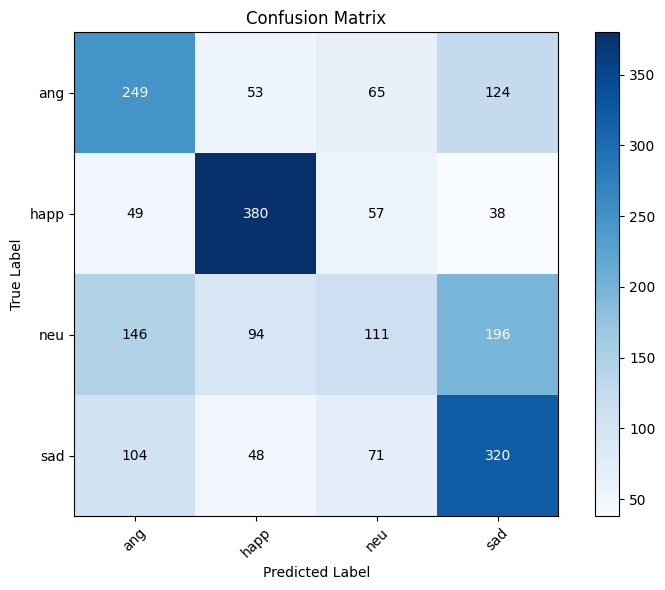

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Example confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues')  # Change colormap to blues
plt.colorbar()

classes = ['ang', 'happ','neu','sad']
# Show class labels on each axis
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)

# Add text annotations
thresh = conf_matrix.max() / 2.0
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()


# Save the plot as an image file
plt.savefig('/content/Confusion_Matrix_DenseModel.png')
#plt.savefig('/content/Confusion_Matrix_LSTMModel.png')

plt.show()
# Use the file upload feature to upload the plot to your Google Drive
from google.colab import files
files.download('/content/Confusion_Matrix_DenseModel.png')
#files.download('/content/Confusion_Matrix_LSTMModel.png')
